## Select Pathologies

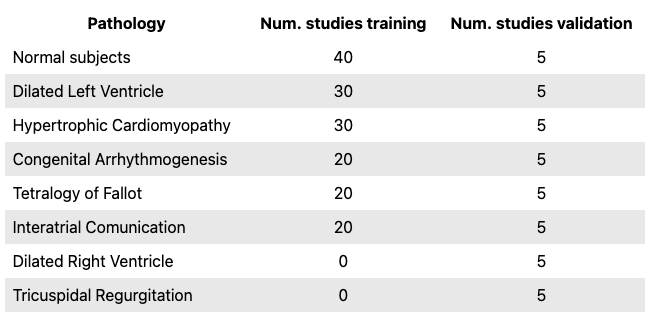

The training set contained 200 annotated images. You can select **at least 2 pathologies (>= 2)** ti train your deep learning models.

## Pre-processing Raw Data

To pre-process the raw data, setup the folder structure as below:

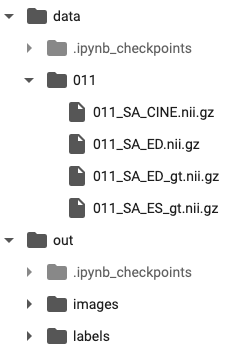

In [ ]:
import os
import nibabel as nib
import numpy as np

In [ ]:
path_data = '/content/data/'
path_out = '/content/out/'

In [ ]:
for (dirpath, dirnames, filenames) in os.walk(path_data):
    for file in filenames:

        if file.split('_')[1] == 'SA':
            dir_patient = file.split('_')[0]
            # print(dir_patient)
            if file.split('_')[2].split('.')[0] != 'CINE':
                # print(os.path.join(path_data+dir_patient+'/', file))
                if 'gt' not in file:
                    original = nib.load(os.path.join(path_data+dir_patient+'/', file)).get_fdata()
                    affine = nib.load(os.path.join(path_data+dir_patient+'/', file)).affine
                    hdr = nib.load(os.path.join(path_data+dir_patient+'/', file)).header

                    for i in range(original.shape[2]):
                        out = nib.Nifti1Image(original, affine, header=hdr)
                        nib.save(out, os.path.join(path_out+'images/', file.split('.')[0]+'_'+format(i,"04")+'.nii.gz'))
                else:
                    original_gt = nib.load(os.path.join(path_data+dir_patient+'/', file.split('.')[0]+'.nii.gz')).get_fdata()
                    affine_gt = nib.load(os.path.join(path_data+dir_patient+'/', file.split('.')[0]+'.nii.gz')).affine
                    hdr_gt = nib.load(os.path.join(path_data+dir_patient+'/', file.split('.')[0]+'.nii.gz')).header

                    for i in range(original_gt.shape[2]):
                        out_gt = nib.Nifti1Image(original_gt, affine_gt, header=hdr_gt)
                        nib.save(out_gt, os.path.join(path_out+'labels/', file.split('.')[0]+'_'+format(i,"04")+'.nii.gz'))

## Data Visualization

To visualize the raw MRI images, [3D Slicer](https://https://www.slicer.org/) is a free, open source software for analyzing and understanding medical image data.

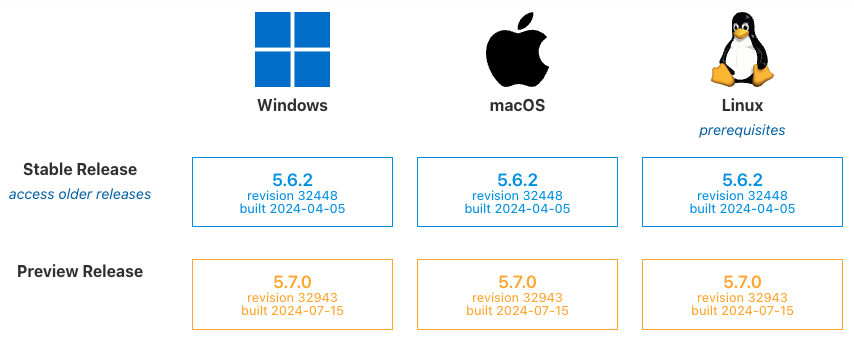

## An Example Model: U-Net


https://doi.org/10.48550/arXiv.1505.04597

In [ ]:
import torch
from torch import nn

from collections import OrderedDict

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))

                ]
            )
        )